# BERT (Encoder-only-model)

- Token classification 
    NER
- Sequence classification
    Sentiment Classification
    Relation Extraction (RE)
- Text Clustering (BERTopic)
    Embedding model
    Clustering model
    使用Representation方法去微調主題表示


In [143]:

import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# 載入資料集
fake_df = pd.read_csv('./raw_data/fake.csv')
true_df = pd.read_csv('./raw_data/true.csv')

# 加上 label 欄位
fake_df['label'] = 1
true_df['label'] = 0

# 取前 10000 筆
data = pd.concat([fake_df.iloc[:10000], true_df.iloc[:10000]], ignore_index=True)
data = data[data['text'].notna()].reset_index(drop=True)

# 檢查各類別數量
print(data['label'].value_counts())


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


label
1    10000
0    10000
Name: count, dtype: int64


## 需要做文本預處理嗎?

目的:
- 建立分類器來預測真假新聞 -> (TF-IDF + 分類模型需要乾淨的資料，有幫助)
- 分析NER 結果與語意分佈 -> (會破壞語意)
- 建立主題模型來探索語意主題（BERTopic -> (會破壞語意)

In [144]:

lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z ]', '', text)
    tokens = word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return tokens

data['tokens'] = data['text'].astype(str).apply(preprocess)
data['clean_text'] = data['tokens'].apply(lambda x: ' '.join(x))



## NER 預測新聞真假

In [145]:
from matplotlib.font_manager import fontManager
import matplotlib.pyplot as plt

fontManager.addfont('./public/TaipeiSansTCBeta-Regular.ttf')
plt.rcParams['font.sans-serif'] = ['Taipei Sans TC Beta']
plt.rcParams['font.size'] = '16'

In [146]:
from sklearn.cluster import KMeans
from bertopic import BERTopic
from bertopic.vectorizers import ClassTfidfTransformer
from hdbscan import HDBSCAN
from transformers import BertTokenizerFast, AutoTokenizer, AutoModelForTokenClassification, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm

# 載入模型與 tokenizer
tokenizer = AutoTokenizer.from_pretrained("dslim/bert-base-NER")
model = AutoModelForTokenClassification.from_pretrained("dslim/bert-base-NER")
ner_pipeline = pipeline("ner", model=model, tokenizer=tokenizer, aggregation_strategy="simple")

# 建立 NER 結果列表
ner_rows = []

# 分切字串
def split_text(text, chunk_size=512):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# 針對每篇文章跑 NER（可用 tqdm 顯示進度條）
for idx, text in tqdm(data['text'].astype(str).items()):
    try:
        chunks = split_text(text)
        all_ents = []
        for chunk in chunks:
            all_ents.extend(ner_pipeline(chunk))  # 對每段跑 NER
        for ent in all_ents:
            ner_rows.append({
                "index": idx,
                "entity": ent['entity_group'],  # e.g., PER, LOC
                "word": ent['word'],
                "score": ent['score']
            })
    except Exception as e:
        print(f"Error at idx {idx}: {e}")

# 建立 DataFrame
ner_df = pd.DataFrame(ner_rows)

Some weights of the model checkpoint at dslim/bert-base-NER were not used when initializing BertForTokenClassification: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
20000it [2:19:33,  2.39it/s]


In [147]:
ner_df.head(10)


,index,entity,word,score
0,0,PER,Donald Trump,0.999043
1,0,MISC,Americans,0.998977
2,0,LOC,Country,0.512393
3,0,ORG,F,0.991836
4,0,ORG,##ake News Media,0.968911
5,0,PER,Angry Pants,0.864726
6,0,LOC,America,0.999604
7,0,ORG,Fake News Media,0.917655
8,0,LOC,America,0.999512
9,0,PER,Donald J. Trump,0.886408


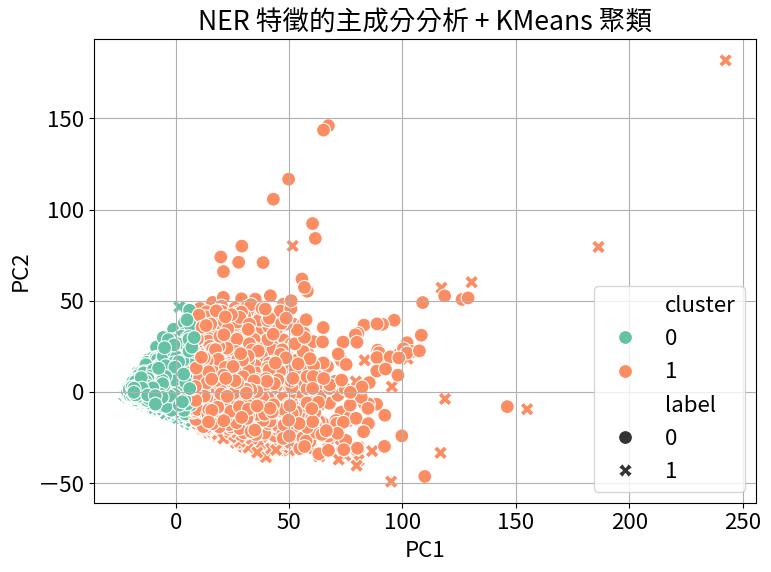

In [148]:
# 整合 label
merged_df = ner_df.merge(data[['label']], left_on='index', right_index=True)

# 聚合所有 entity 類型的出現次數
entity_counts_all = (
    merged_df.groupby(['index', 'entity'])
    .size()
    .unstack(fill_value=0)  # 得到每篇文章各類實體數
    .reset_index()
)

# 合併 label
entity_counts_all = entity_counts_all.merge(data[['label']], left_on='index', right_index=True)

# 建模欄位選擇：所有實體類別欄位（排除 index, label）
feature_cols = [col for col in entity_counts_all.columns if col not in ['index', 'label']]
kmeans_fit_pred_data = entity_counts_all[feature_cols]

# 做 KMeans 聚類
from sklearn.cluster import KMeans
import seaborn as sns

kmeans = KMeans(n_clusters=2, random_state=42)
entity_counts_all['cluster'] = kmeans.fit_predict(kmeans_fit_pred_data)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(kmeans_fit_pred_data)
entity_counts_all['PC1'] = X_pca[:, 0]
entity_counts_all['PC2'] = X_pca[:, 1]
# 視覺化聚類結果
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=entity_counts_all,
    x='PC1', y='PC2', hue='cluster', style='label',
    palette='Set2', s=100
)

plt.title('NER 特徵的主成分分析 + KMeans 聚類')
plt.grid(True)
plt.tight_layout()
plt.show()

#### 嘗試用 NER 提取出的'人名'、'組織'、'地名數量'作為詞彙特徵，再餵給 TF-IDF + 模型來預測這篇新聞是真/假

In [149]:
from sklearn.ensemble import RandomForestClassifier

# 聚合 ner_df 結果為特徵表（以 index = 文章編號為 key）
entity_counts = ner_df.groupby(['index', 'entity']).size().unstack(fill_value=0)

# 合併回原資料集
data_with_ner = data.copy()
data_with_ner = data_with_ner.join(entity_counts, how='left').fillna(0)

# 建立特徵：人名、組織、地名數量
ner_pred_X = data_with_ner[['PER', 'ORG', 'LOC']]
ner_pred_y = data_with_ner['label']

# 建模
# Logistic Regression
X_train, X_test, y_train, y_test = train_test_split(ner_pred_X, ner_pred_y, test_size=0.2, random_state=42)
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred = lr_clf.predict(X_test)

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)
rf_y_pred = rf_clf.predict(X_test)

# Logistic Regression 結果
print("=== LogisticRegression 分類結果 ===")
print(classification_report(y_test, lr_pred))

# Random Forest 結果
print("=== RandomForestClassifier 分類結果 ===")
print(classification_report(y_test, rf_y_pred))

=== LogisticRegression 分類結果 ===
              precision    recall  f1-score   support

           0       0.74      0.65      0.69      1981
           1       0.69      0.77      0.73      2019

    accuracy                           0.71      4000
   macro avg       0.71      0.71      0.71      4000
weighted avg       0.71      0.71      0.71      4000

=== RandomForestClassifier 分類結果 ===
              precision    recall  f1-score   support

           0       0.73      0.75      0.74      1981
           1       0.75      0.72      0.74      2019

    accuracy                           0.74      4000
   macro avg       0.74      0.74      0.74      4000
weighted avg       0.74      0.74      0.74      4000



### NER提取特徵預測結果尚可
小結:
預測真新聞:  LR      RF
precision   0.71    0.75
recall      0.62    0.74
f1          0.66    0.74

預測假新聞:
precision   0.66    0.74
recall      0.74    0.75
f1          0.70    0.74

NER 特徵對真假新聞辨識有一定程度作用，且用RandomForest的結果較優

## 使用情緒分析辨識真假新聞

In [ ]:
# 載入情緒分析模型(微調後的BERT)
model = pipeline("sentiment-analysis", model="distilbert-base-uncased-finetuned-sst-2-english")
# 因為這個語言也是BERT = 效果仰賴'自然語言語序與上下文' = 使用data['text']即可

# 切割文字 每段不超過 512 字
def split_text(text, chunk_size=512):
    return [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

# 整合段落的情緒分數
def analyze_long_text(text):
    try:
        chunks = split_text(text)
        results = model(chunks)

        # 統計情緒
        pos_scores = [r['score'] for r in results if r['label'] == 'POSITIVE']
        neg_scores = [r['score'] for r in results if r['label'] == 'NEGATIVE']

        # 平均分數
        avg_pos = sum(pos_scores) / len(pos_scores) if pos_scores else 0
        avg_neg = sum(neg_scores) / len(neg_scores) if neg_scores else 0

        # 決定總體情續
        if avg_pos > avg_neg:
            return pd.Series(['POSITIVE', avg_pos])
        elif avg_neg > avg_pos:
            return pd.Series(['NEGATIVE', avg_neg])
        else:
            return pd.Series(['NEUTRAL', 0.5])
    except Exception:
        return pd.Series(['ERROR', 0.0])

# 執行分析
tqdm.pandas()
data[['sentiment_label', 'sentiment_score']] = data['text'].progress_apply(analyze_long_text)

data.head(10)

Device set to use cpu
100%|██████████| 20000/20000 [1:07:01<00:00,  4.97it/s]


,title,text,subject,date,label,tokens,clean_text,sentiment_label,sentiment_score
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1,"[donald, trump, wish, american, happy, new, ye...",donald trump wish american happy new year leav...,POSITIVE,0.995209
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1,"[house, intelligence, committee, chairman, dev...",house intelligence committee chairman devin nu...,NEGATIVE,0.997675
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1,"[friday, revealed, former, milwaukee, sheriff,...",friday revealed former milwaukee sheriff david...,NEGATIVE,0.995043
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1,"[christmas, day, donald, trump, announced, wou...",christmas day donald trump announced would bac...,NEGATIVE,0.981710
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1,"[pope, francis, used, annual, christmas, day, ...",pope francis used annual christmas day message...,POSITIVE,0.991508
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017",1,"[number, case, cop, brutalizing, killing, peop...",number case cop brutalizing killing people col...,NEGATIVE,0.995830
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017",1,"[donald, trump, spent, good, portion, day, gol...",donald trump spent good portion day golf club ...,NEGATIVE,0.935587
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017",1,"[wake, yet, another, court, decision, derailed...",wake yet another court decision derailed donal...,NEGATIVE,0.934570
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017",1,"[many, people, raised, alarm, regarding, fact,...",many people raised alarm regarding fact donald...,POSITIVE,0.985874
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017",1,"[might, thought, get, break, watching, people,...",might thought get break watching people kiss d...,NEGATIVE,0.998032


In [151]:
sentiment_pred_X = data[['sentiment_score']]
sentiment_pred_y = data['label']

# 分割訓練與測試集
X_train, X_test, y_train, y_test = train_test_split(sentiment_pred_X, sentiment_pred_y, test_size=0.2, random_state=42)

# 建立模型並訓練
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)

# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train, y_train)

# 預測與評估
y_pred = lr_clf.predict(X_test)
print(classification_report(y_test, y_pred))

# 預測與評估
rf_y_pred = rf_clf.predict(X_test)
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.57      0.36      0.44      1981
           1       0.54      0.73      0.62      2019

    accuracy                           0.55      4000
   macro avg       0.55      0.54      0.53      4000
weighted avg       0.55      0.55      0.53      4000

              precision    recall  f1-score   support

           0       0.51      0.51      0.51      1981
           1       0.52      0.51      0.52      2019

    accuracy                           0.51      4000
   macro avg       0.51      0.51      0.51      4000
weighted avg       0.51      0.51      0.51      4000



### 小結: 情緒預測真假新聞表現不好
小結:
預測真新聞:  LR      RF
precision   0.60    0.52
recall      0.37    0.50
f1          0.46    0.51

預測假新聞:
precision   0.54    0.52
recall      0.75    0.54
f1          0.63    0.53

整體分類效果偏弱，跟丟銅板差不多
模型偏好預測為假新聞（recall 高），但也多誤判

### 嘗試整合兩者

In [152]:
from sklearn.ensemble import RandomForestClassifier

combined_X = pd.concat([data_with_ner[['PER', 'ORG', 'LOC']], sentiment_pred_X], axis=1)
combined_y = data['label']
# 分割訓練與測試集
X_train, X_test, y_train, y_test = train_test_split(combined_X, combined_y, test_size=0.2, random_state=42)

# Logistic Regression
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
lr_preds = clf_lr.predict(X_test)

# Random Forest
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train, y_train)
rf_preds = clf_rf.predict(X_test)

# 評估結果
print("=== Logistic Regression 分類結果 ===")
print(classification_report(y_test, lr_preds))

print("=== Random Forest 分類結果 ===")
print(classification_report(y_test, rf_preds))

=== Logistic Regression 分類結果 ===
              precision    recall  f1-score   support

           0       0.75      0.65      0.70      1981
           1       0.70      0.78      0.74      2019

    accuracy                           0.72      4000
   macro avg       0.72      0.72      0.72      4000
weighted avg       0.72      0.72      0.72      4000

=== Random Forest 分類結果 ===
              precision    recall  f1-score   support

           0       0.74      0.77      0.76      1981
           1       0.77      0.74      0.75      2019

    accuracy                           0.75      4000
   macro avg       0.75      0.75      0.75      4000
weighted avg       0.76      0.75      0.75      4000



### 整合特徵後整體預測準確度上升

NER:
=== LogisticRegression 分類結果 ===
              precision    recall  f1-score   support

           0       0.71      0.62      0.66       201
           1       0.66      0.74      0.70       199

    accuracy                           0.68       400
   macro avg       0.68      0.68      0.68       400
weighted avg       0.68      0.68      0.68       400

=== RandomForestClassifier 分類結果 ===
              precision    recall  f1-score   support

           0       0.75      0.74      0.74       201
           1       0.74      0.75      0.75       199

    accuracy                           0.74       400
   macro avg       0.75      0.75      0.74       400
weighted avg       0.75      0.74      0.74       400



情緒分析:
              precision    recall  f1-score   support

           0       0.60      0.37      0.46       201
           1       0.54      0.75      0.63       199

    accuracy                           0.56       400
   macro avg       0.57      0.56      0.55       400
weighted avg       0.57      0.56      0.55       400

              precision    recall  f1-score   support

           0       0.52      0.50      0.51       201
           1       0.52      0.54      0.53       199

    accuracy                           0.52       400
   macro avg       0.52      0.52      0.52       400
weighted avg       0.52      0.52      0.52       400




整合後:
=== Logistic Regression 分類結果 ===
              precision    recall  f1-score   support

           0       0.73      0.67      0.70       201
           1       0.69      0.75      0.72       199

    accuracy                           0.71       400
   macro avg       0.71      0.71      0.71       400
weighted avg       0.71      0.71      0.71       400

=== Random Forest 分類結果 ===
              precision    recall  f1-score   support

           0       0.80      0.77      0.79       201
           1       0.78      0.81      0.79       199

    accuracy                           0.79       400
   macro avg       0.79      0.79      0.79       400
weighted avg       0.79      0.79      0.79       400

In [153]:
# 嘗試增加TF-IDF欄位(clean_text)

# 建立 TF-IDF 向量器（可自訂 ngram 範圍與維度限制）
tfidf = TfidfVectorizer(max_features=200, ngram_range=(1, 2))
tfidf_matrix = tfidf.fit_transform(data['clean_text'].fillna(''))

# 轉為 DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf.get_feature_names_out(), index=data.index)

# 新增tf-idf欄位
ner_sentiment_df = pd.concat([ner_pred_X, sentiment_pred_X], axis=1)
combined_X_full = pd.concat([ner_sentiment_df, tfidf_df], axis=1)

# 分割資料
X_train, X_test, y_train, y_test = train_test_split(combined_X_full, combined_y, test_size=0.2, random_state=42)

# Logistic
clf_lr = LogisticRegression()
clf_lr.fit(X_train, y_train)
lr_preds = clf_lr.predict(X_test)

# Random Forest
clf_rf = RandomForestClassifier(random_state=42)
clf_rf.fit(X_train, y_train)
rf_preds = clf_rf.predict(X_test)

# 評估
print("=== Logistic Regression(NER + Sentiment + TF-IDF) ===")
print(classification_report(y_test, lr_preds))

print("=== Random Forest(NER + Sentiment + TF-IDF) ===")
print(classification_report(y_test, rf_preds))

=== Logistic Regression(NER + Sentiment + TF-IDF) ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      1981
           1       0.98      0.98      0.98      2019

    accuracy                           0.98      4000
   macro avg       0.98      0.98      0.98      4000
weighted avg       0.98      0.98      0.98      4000

=== Random Forest(NER + Sentiment + TF-IDF) ===
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1981
           1       0.99      1.00      1.00      2019

    accuracy                           1.00      4000
   macro avg       1.00      1.00      1.00      4000
weighted avg       1.00      1.00      1.00      4000



### 過擬合?

=== Logistic Regression(NER + Sentiment + TF-IDF) ===
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       201
           1       0.99      0.96      0.98       199

    accuracy                           0.98       400
   macro avg       0.98      0.98      0.98       400
weighted avg       0.98      0.98      0.98       400

=== Random Forest(NER + Sentiment + TF-IDF) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       201
           1       0.99      1.00      1.00       199

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400

- 修正: TfidfVectorizer max_features=1000 -> 200
- 修正: 資料各取1000筆 -> 10000筆

In [154]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(clf_rf, combined_X_full, combined_y, cv=5, scoring='f1')
print(f"5-fold F1 scores: {scores}")
print(f"Mean F1: {scores.mean():.4f}")

5-fold F1 scores: [0.99428003 0.99825131 0.99825044 0.99824956 0.9867068 ]
Mean F1: 0.9951


### Topic model: BERTopic 主題詞來源使用c-TF-IDF頻率導向，挑出詞頻高的詞

In [155]:
from sklearn.feature_extraction.text import CountVectorizer

# 真假新聞進行主題建模
docs = data['text'].astype(str).tolist()

# 模型可換成 'all-MiniLM-L6-v2', 'microsoft/Phi-4-mini-instruct' 等
embedding_model = 'all-MiniLM-L6-v2'

# 可調整 測試用2000筆
# min_cluster_size 群集最少需要包含n個點，否則會被視為雜訊（noise）
# min_samples 包含至少n篇文章的主題才會被承認為主題
hdbscan_model = HDBSCAN(min_cluster_size=10, min_samples=30) # Clustering layer
vectorizer_model = CountVectorizer(ngram_range=(1, 2), stop_words="english")

topic_model = BERTopic(embedding_model=embedding_model, hdbscan_model=hdbscan_model, vectorizer_model=vectorizer_model)
topics, probs = topic_model.fit_transform(docs)


In [156]:
# 建立一個儲存所有主題關鍵詞與 TF-IDF 分數的清單
all_topics = []

# 把主題總數拿出來（排除 -1 是未分類主題）
valid_topics = [topic for topic in topic_model.get_topic_info().Topic if topic != -1]

# 對每個主題取得詞與 c-TF-IDF 分數
for topic_id in valid_topics:
    topic_words = topic_model.get_topic(topic_id)
    for word, score in topic_words:
        all_topics.append({
            "Topic": topic_id,
            "Word": word,
            "C-TF-IDF": score
        })

# 轉換成 DataFrame 並排序
topic_tfidf_df = pd.DataFrame(all_topics)
topic_tfidf_df = topic_tfidf_df.sort_values(by=["Topic", "C-TF-IDF"], ascending=[True, False])

# 顯示前幾列
topic_tfidf_df.head(20)

,Topic,Word,C-TF-IDF
0,0,gun,0.008948
1,0,police,0.007674
2,0,black,0.007422
3,0,people,0.006168
4,0,white,0.005251
5,0,racist,0.004392
6,0,guns,0.004024
7,0,trump,0.003969
8,0,violence,0.003917
9,0,image,0.003864


In [157]:

# 列出文章的BERTopic資訊
topic_model.get_document_info(docs)

,Document,Topic,Name,Representation,Representative_Docs,Top_n_words,Probability,Representative_document
0,Donald Trump just couldn t wish all Americans ...,-1,-1_trump_said_president_donald,"[trump, said, president, donald, clinton, dona...","[HOLLYWOOD, Fla./WASHINGTON (Reuters) - Republ...",trump - said - president - donald - clinton - ...,0.000000,False
1,House Intelligence Committee Chairman Devin Nu...,-1,-1_trump_said_president_donald,"[trump, said, president, donald, clinton, dona...","[HOLLYWOOD, Fla./WASHINGTON (Reuters) - Republ...",trump - said - president - donald - clinton - ...,0.000000,False
2,"On Friday, it was revealed that former Milwauk...",0,0_gun_police_black_people,"[gun, police, black, people, white, racist, gu...",[Talk show legend Montel Williams is a conserv...,gun - police - black - people - white - racist...,0.930515,False
3,"On Christmas day, Donald Trump announced that ...",75,75_golf_golfing_golf course_trump,"[golf, golfing, golf course, trump, weekend, v...",[Donald Trump repeatedly attacked former Presi...,golf - golfing - golf course - trump - weekend...,0.674130,False
4,Pope Francis used his annual Christmas Day mes...,118,118_pope_francis_pope francis_vatican,"[pope, francis, pope francis, vatican, catholi...",[Pope Francis is now the anti-Christ in the ey...,pope - francis - pope francis - vatican - cath...,0.706901,False
...,...,...,...,...,...,...,...,...
19995,WASHINGTON (Reuters) - U.S. President Barack O...,10,10_clinton_fbi_email_emails,"[clinton, fbi, email, emails, comey, server, c...",[WASHINGTON/NEW YORK (Reuters) - The FBI is in...,clinton - fbi - email - emails - comey - serve...,0.554227,False
19996,LONDON (Reuters) - Planned changes that Presid...,2,2_tax_percent_tax reform_rate,"[tax, percent, tax reform, rate, reform, corpo...",[WASHINGTON (Reuters) - Republican lawmakers o...,tax - percent - tax reform - rate - reform - c...,0.358994,False
19997,WASHINGTON (Reuters) - Democratic front-runner...,11,11_sanders_bernie_clinton_bernie sanders,"[sanders, bernie, clinton, bernie sanders, dem...",[WASHINGTON (Reuters) - Winning over Bernie Sa...,sanders - bernie - clinton - bernie sanders - ...,0.554751,False
19998,(Reuters) - Headlines screaming “Deportations ...,-1,-1_trump_said_president_donald,"[trump, said, president, donald, clinton, dona...","[HOLLYWOOD, Fla./WASHINGTON (Reuters) - Republ...",trump - said - president - donald - clinton - ...,0.000000,False


In [158]:
def visualize_fake_news_ratio_by_topic(model, docs, labels, title="主題的假新聞比例"):
    doc_info = model.get_document_info(docs).copy()
    doc_info['label'] = labels

    # 計算比例與數量
    topic_fake_ratio = (
        doc_info[doc_info['Topic'] != -1]
        .groupby('Topic')['label']
        .mean()
        .reset_index()
        .rename(columns={'label': 'fake_news_ratio'})
    )
    topic_counts = (
        doc_info[doc_info['Topic'] != -1]['Topic']
        .value_counts()
        .rename_axis('Topic')
        .reset_index(name='count')
    )
    topic_stats = pd.merge(topic_fake_ratio, topic_counts, on='Topic')

    # 加上主題名稱
    topic_names = model.get_topic_info()[['Topic', 'Name']]
    topic_stats_named = topic_stats.merge(topic_names, on='Topic')

    # 過濾比例過低的主題
    topic_stats_named = topic_stats_named[topic_stats_named['fake_news_ratio'] >= 0.1]

    # 繪圖
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(
        data=topic_stats_named.sort_values(by='fake_news_ratio', ascending=False),
        x='fake_news_ratio', y='Name', palette='Reds'
    )
    plt.title(title)
    plt.xlabel('假新聞比例 (label=1)')
    plt.ylabel('主題代表詞')
    plt.grid(True, axis='x')
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=9)
    plt.tight_layout()
    plt.show()

### representation topic model: 加上語意導向的KeyBERT, 表現方式是語意向量相似的詞 

In [159]:
from bertopic.representation import KeyBERTInspired
from sentence_transformers import SentenceTransformer

embedding_model_with_st = SentenceTransformer(embedding_model)  # 或其他你指定的模型
embeddings = embedding_model_with_st.encode(docs, show_progress_bar=True)

# 關鍵詞表示模型（非生成式）
keybert = KeyBERTInspired()

# 組裝 representation model
representation_model = {
    "KeyBERT": keybert
}

# 建立 BERTopic 模型（用 KeyBERT 調整主題表示）
representation_topic_model = BERTopic(
    embedding_model=embedding_model_with_st,
    vectorizer_model=vectorizer_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    top_n_words=30,
    verbose=True
)

# 訓練模型
topics, probs = representation_topic_model.fit_transform(docs, embeddings)

# 查看新的主題表示
representation_topic_model.get_topic_info()

Batches:   0%|          | 0/625 [00:00<?, ?it/s]

2025-05-11 01:45:26,331 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-11 01:45:30,061 - BERTopic - Dimensionality - Completed ✓
2025-05-11 01:45:30,063 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-11 01:45:31,596 - BERTopic - Cluster - Completed ✓
2025-05-11 01:45:31,600 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-11 01:46:23,397 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,KeyBERT,Representative_Docs
0,-1,5436,-1_trump_said_president_donald,"[trump, said, president, donald, clinton, dona...","[trump, presidential, clinton, white house, pr...","[HOLLYWOOD, Fla./WASHINGTON (Reuters) - Republ..."
1,0,1697,0_gun_police_black_people,"[gun, police, black, people, white, racist, tr...","[racism, white supremacists, racist, gun contr...",[We know Trump is a sexual predator. We know h...
2,1,811,1_trump_twitter_realdonaldtrump_media,"[trump, twitter, realdonaldtrump, media, donal...","[trump realdonaldtrump, 2017 realdonaldtrump, ...","[It took Donald Trump all day, but he apparent..."
3,2,758,2_obamacare_insurance_healthcare_health,"[obamacare, insurance, healthcare, health, car...","[repeal obamacare, replace obamacare, obamacar...","[(Reuters) - After months of internal discord,..."
4,3,484,3_tax_percent_tax reform_rate,"[tax, percent, tax reform, rate, reform, corpo...","[tax cuts, tax overhaul, tax cut, republican t...",[WASHINGTON (Reuters) - U.S. President Donald ...
...,...,...,...,...,...,...
126,125,18,125_meet_trump meet_leader_house,"[meet, trump meet, leader, house, washington r...","[trump meet, meeting trump, meet republican, m...",[WASHINGTON (Reuters) - Democratic leaders in ...
127,126,18,126_puerto_puerto rico_rico_island,"[puerto, puerto rico, rico, island, aid, billi...","[helping puerto, rebuild puerto, help puerto, ...",[WASHINGTON (Reuters) - President Donald Trump...
128,127,17,127_steel_ross_trade_imports,"[steel, ross, trade, imports, ross said, tinto...","[steel imports, new tariffs, tariffs, steel in...",[WASHINGTON (Reuters) - U.S. Commerce Secretar...
129,128,17,128_carson_hud_ben carson_housing,"[carson, hud, ben carson, housing, ben, neuros...","[carson endorsed, carson campaign, ben carson,...","[During an appearance on CNN on Tuesday, Repub..."


In [160]:
# 視覺化主題分布：圓圈大小是主題的大小，圓圈的距離是主題之間的相似度
topic_model.visualize_topics()

In [161]:
representation_topic_model.visualize_topics()

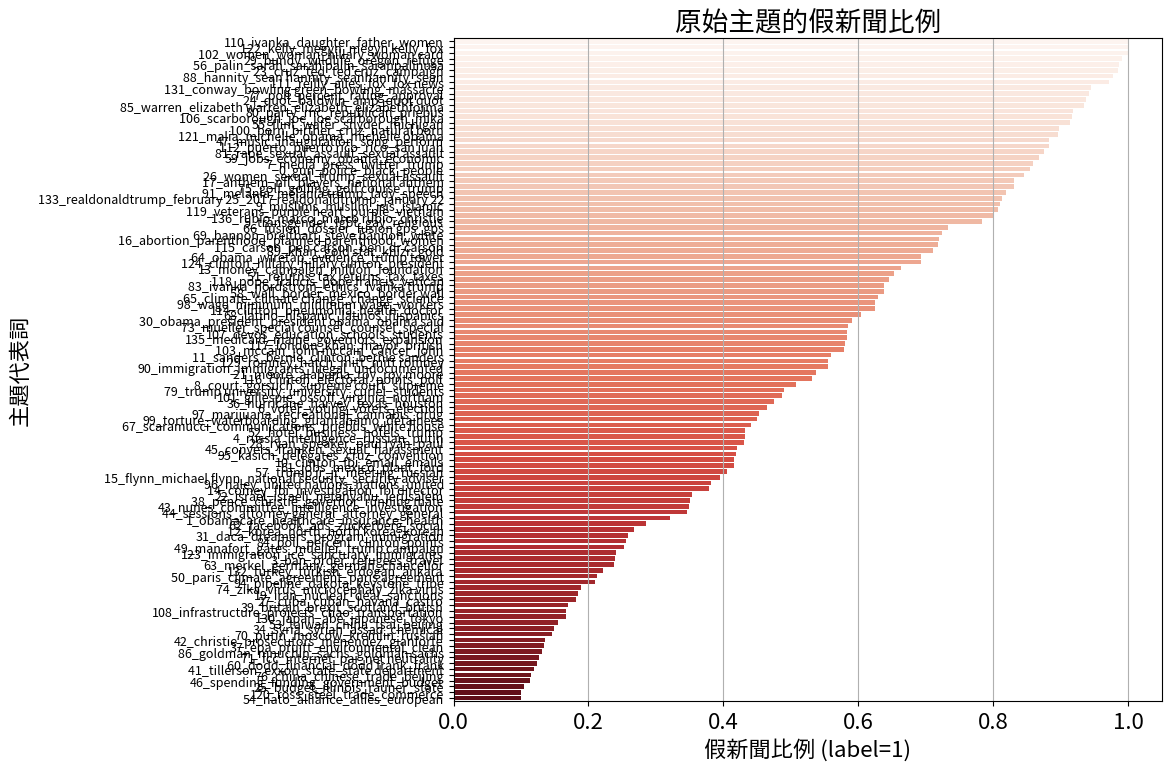

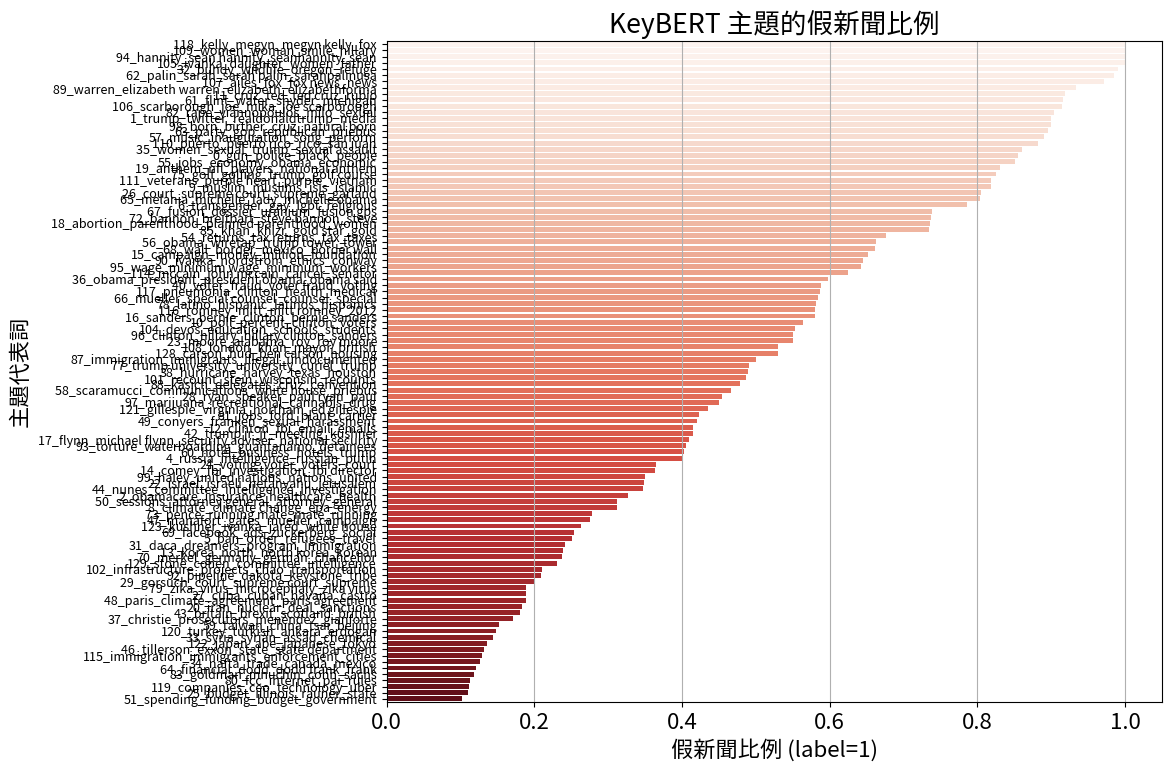

In [162]:
# 原始模型的主題
visualize_fake_news_ratio_by_topic(topic_model, docs, data['label'], title="原始主題的假新聞比例")

# 使用 KeyBERT 表示詞的模型主題
visualize_fake_news_ratio_by_topic(representation_topic_model, docs, data['label'], title="KeyBERT 主題的假新聞比例")